In [1]:
import numpy as np
import matplotlib as mpl
from scipy import stats
from matplotlib import pyplot as plt
from Bio import pairwise2
from Bio.SubsMat.MatrixInfo import blosum62
import pandas as pd
import seaborn as sns
import sys

# import utils
sys.path.append("../")
sys.path.append("../data_loading")

import plotting
from plotting import (mimic_r_boxplot,
                      violinplot_reflected,
                      y1h_pdi_per_paralog_pair_plot,
                      m1h_activation_per_paralog_pair_plot,
                      annotate_pval)

from data_loading import (load_paralogs_vs_isoforms_comparison_table,
                          load_developmental_tissue_expression_remapped,
                          load_gtex_remapped,
                          load_annotated_TFiso1_collection,
                          load_y1h_pdi_data,
                          load_m1h_activation_data,
                          load_pfam_clans,
                          load_annotated_gencode_tfs)

In [2]:
PAPER_PRESET = {"style": "ticks", "font": "Helvetica", "context": "paper", 
                "rc": {"font.size":7,"axes.titlesize":7,
                       "axes.labelsize":7, 'axes.linewidth':0.5,
                       "legend.fontsize":6, "xtick.labelsize":6,
                       "ytick.labelsize":6, "xtick.major.size": 3.0,
                       "ytick.major.size": 3.0, "axes.edgecolor": "black",
                       "xtick.major.pad": 3.0, "ytick.major.pad": 3.0}}
PAPER_FONTSIZE = 7

In [3]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [4]:
np.random.seed(2023)

## 1. load paralogs vs. isoforms data table

note that this takes hours the first time you run it (the pairwise seq alignment command is very slow), but then it is cached so only need to run once.

In [5]:
df = load_paralogs_vs_isoforms_comparison_table()
df.loc[~((df['n_positive_PPI_a'] >= 1) & (df['n_positive_PPI_b'] >= 1)),
       'PPI_jaccard'] = np.nan
df['PPI_Jaccard_d'] = 1 - df['PPI_jaccard']
df['PDI_Jaccard_d'] = 1 - df['PDI_jaccard']
df.loc[(df['activation_a'].abs() < 1) &
       (df['activation_b'].abs() < 1), 
       'activation_abs_fold_change_log2'] = np.nan

In [6]:
df.head()

,gene_symbol_a,gene_symbol_b,is_tested_in_Y2H,aa_seq_pct_identity,clone_acc_a,clone_acc_b,category,family_a,family_b,is_MANE_select_isoform_cloned_a,...,n_positive_PDI_b_filtered,n_shared_PDI,PDI_jaccard,at_least_one_isoform_in_gene_a_abs_activation_gte_2fold,at_least_one_isoform_in_gene_b_abs_activation_gte_2fold,activation_a,activation_b,activation_abs_fold_change_log2,PPI_Jaccard_d,PDI_Jaccard_d
0,ZKSCAN3,ZNF263,False,34.555712,ZKSCAN3|2/2|07C05,ZNF263|1/3|11C01,paralogs,C2H2 ZF,C2H2 ZF,False,...,NaN,NaN,NaN,True,True,1.571580,4.407654,2.836075,NaN,NaN
1,ZNF263,ZSCAN21,False,33.664773,ZNF263|1/3|11C01,ZSCAN21|1/3|10H09,paralogs,C2H2 ZF,C2H2 ZF,True,...,NaN,NaN,NaN,True,True,4.407654,1.410804,2.996850,NaN,NaN
2,ZNF24,ZNF263,False,25.070822,ZNF24|1/2|01B07,ZNF263|1/3|11C01,paralogs,C2H2 ZF,C2H2 ZF,True,...,NaN,NaN,NaN,False,True,0.641802,4.407654,3.765852,0.5,NaN
3,ZNF263,ZNF75A,False,19.683908,ZNF263|1/3|11C01,ZNF75A|1/2|11B06,paralogs,C2H2 ZF,C2H2 ZF,True,...,NaN,NaN,NaN,True,False,4.407654,-0.763338,5.170992,NaN,NaN
4,ZNF263,ZSCAN25,True,33.146853,ZNF263|1/3|11C01,ZSCAN25|1/4|04A06,paralogs,C2H2 ZF,C2H2 ZF,True,...,NaN,NaN,NaN,True,True,4.407654,1.294304,3.113350,NaN,NaN


## 2. plot differences in molecular functions across paralogs/isoforms

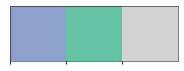

In [7]:
pal = {"isoforms": sns.color_palette("Set2")[2],
       "paralogs": sns.color_palette("Set2")[0],
       "non-paralog-control": "lightgrey"}
sns.palplot(pal.values())

5.966154712014808e-05
0.015142969349353753


../plotting.py:1005: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1, c="black", linewidth=0.5)
../plotting.py:1005: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1, c="black", linewidth=0.5)


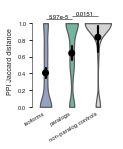

In [8]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=1.5, h=2)
violinplot_reflected(data=df,
            x='category',
            y='PPI_Jaccard_d',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            inner=None,
            width=1.,
            clip_on=False,
            cut=0,
            ax=ax,
            palette=pal
            )
sns.pointplot(data=df,
            x='category',
            y='PPI_Jaccard_d',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            color='black',
            linestyles='',
            ax=ax,
            clip_on=False,
            )
for loc in ['right', 'top', 'bottom']:
    ax.spines[loc].set_visible(False)
ax.set_xlim(-0.5, 2.7)
ax.set_xlabel('')
ax.xaxis.set_tick_params(length=0)
ax.set_ylabel('PPI Jaccard distance')
ax.set_xticklabels(['isoforms', 'paralogs', 'non-paralog controls'], rotation=30, va='top', ha='right')

# calculate p-values
# isos v paralogs
dist_a = list(df[df['category'] == 'isoforms']['PPI_Jaccard_d'])
dist_a = [x for x in dist_a if not pd.isnull(x)]
dist_b = list(df[df['category'] == 'paralogs']['PPI_Jaccard_d'])
dist_b = [x for x in dist_b if not pd.isnull(x)]
u, p = stats.mannwhitneyu(dist_a, dist_b, alternative="two-sided")
print(p)
annotate_pval(ax, 0, 1, 1.05, 0, 1.05, p, PAPER_FONTSIZE - 1)

# paralogs v ctrls
dist_c = list(df[df['category'] == 'non-paralog-control']['PPI_Jaccard_d'])
dist_c = [x for x in dist_c if not pd.isnull(x)]
u, p = stats.mannwhitneyu(dist_b, dist_c, alternative="two-sided")
print(p)
annotate_pval(ax, 1, 2, 1.08, 0, 1.08, p, PAPER_FONTSIZE - 1)

# manually set left axis so it stops at 1.0
ax.set_ylim((-0.1, 1.2))
ax.spines['left'].set_visible(False)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
axes_to_data = ax.transAxes + ax.transData.inverted()
left_spine_in_data_coords = axes_to_data.transform((0, 0))
ax.plot([left_spine_in_data_coords[0], left_spine_in_data_coords[0]], [0, 1],
         color=ax.spines['bottom'].get_edgecolor(), linewidth=ax.spines['bottom'].get_linewidth())
ax.tick_params(axis='x', which='major', pad=-5)

fig.savefig('../../figures/fig6/isoforms_vs_paralogs_PPI_jaccard_violin.pdf',
            bbox_inches='tight')

9.618916692218617e-07
5.1322865181101005e-05


../plotting.py:1005: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1, c="black", linewidth=0.5)
../plotting.py:1005: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1, c="black", linewidth=0.5)


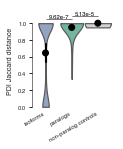

In [9]:
# TODO: there are so many points at 0 in the control that it's tricky to show
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=1.5, h=2)
violinplot_reflected(data=df,
            x='category',
            y='PDI_Jaccard_d',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            inner=None,
            clip_on=False,
            width=1,
            cut=0,
            ax=ax,
            palette=pal
            )
sns.pointplot(data=df,
            x='category',
            y='PDI_Jaccard_d',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            color='black',
            linestyles='',
            ax=ax,
            clip_on=False,
            )
for loc in ['right', 'top', 'bottom']:
    ax.spines[loc].set_visible(False)
ax.set_xlim(-0.5, 2.7)
ax.set_ylim(0, 1)
ax.set_xlabel('')
ax.xaxis.set_tick_params(length=0)
ax.set_ylabel('PDI Jaccard distance')
ax.set_xticklabels(['isoforms', 'paralogs', 'non-paralog controls'], rotation=30, va='top', ha='right')

# calculate p-values
# isos v paralogs
dist_a = list(df[df['category'] == 'isoforms']['PDI_Jaccard_d'])
dist_a = [x for x in dist_a if not pd.isnull(x)]
dist_b = list(df[df['category'] == 'paralogs']['PDI_Jaccard_d'])
dist_b = [x for x in dist_b if not pd.isnull(x)]
u, p = stats.mannwhitneyu(dist_a, dist_b, alternative="two-sided")
print(p)
annotate_pval(ax, 0, 1, 1.05, 0, 1.05, p, PAPER_FONTSIZE - 1)

# paralogs v ctrls
dist_c = list(df[df['category'] == 'non-paralog-control']['PDI_Jaccard_d'])
dist_c = [x for x in dist_c if not pd.isnull(x)]
u, p = stats.mannwhitneyu(dist_b, dist_c, alternative="two-sided")
print(p)
annotate_pval(ax, 1, 2, 1.08, 0, 1.08, p, PAPER_FONTSIZE - 1)

# manually set left axis so it stops at 1.0
ax.set_ylim((-0.1, 1.2))
ax.spines['left'].set_visible(False)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
axes_to_data = ax.transAxes + ax.transData.inverted()
left_spine_in_data_coords = axes_to_data.transform((0, 0))
ax.plot([left_spine_in_data_coords[0], left_spine_in_data_coords[0]], [0, 1],
         color=ax.spines['bottom'].get_edgecolor(), linewidth=ax.spines['bottom'].get_linewidth())
ax.tick_params(axis='x', which='major', pad=-5)

fig.savefig('../../figures/fig6/isoforms_vs_paralogs_PDI_jaccard_violin.pdf',
            bbox_inches='tight')

5.741976377019895e-09
2.069373750683726e-08


../plotting.py:1005: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1, c="black", linewidth=0.5)
../plotting.py:1005: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1, c="black", linewidth=0.5)


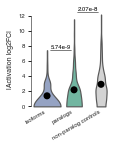

In [10]:
# HACK should just be using violoin plot but it's broken by the reflection
# HACK so just putting very high upper bound
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=1.5, h=1.75)
violinplot_reflected(data=df,
            x='category',
            y='activation_abs_fold_change_log2',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            inner=None,
            width=1.,
            ub=9999999,
            bw_const=0.5,
            cut=0,
            clip_on=False,
            ax=ax,
            palette=pal
            )
sns.pointplot(data=df,
            x='category',
            y='activation_abs_fold_change_log2',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            color='black',
            linestyles='',
            ax=ax,
            clip_on=False,
            )
for loc in ['right', 'top', 'bottom']:
    ax.spines[loc].set_visible(False)
ax.set_ylim(0, 12)
ax.set_xlim(-0.6, 2.5)
ax.set_xlabel('')
ax.xaxis.set_tick_params(length=0)
ax.set_ylabel('|Activation log2FC|')
ax.set_xticklabels(['isoforms', 'paralogs', 'non-paralog controls'], rotation=30, va='top', ha='right')

# calculate p-values
# isos v paralogs
dist_a = list(df[df['category'] == 'isoforms']['activation_abs_fold_change_log2'])
dist_a = [x for x in dist_a if not pd.isnull(x)]
dist_b = list(df[df['category'] == 'paralogs']['activation_abs_fold_change_log2'])
dist_b = [x for x in dist_b if not pd.isnull(x)]
u, p = stats.mannwhitneyu(dist_a, dist_b, alternative="two-sided")
print(p)
annotate_pval(ax, 0.1, 0.9, 7.5, 0, 7.5, p, PAPER_FONTSIZE - 1)

# paralogs v ctrls
dist_c = list(df[df['category'] == 'non-paralog-control']['activation_abs_fold_change_log2'])
dist_c = [x for x in dist_c if not pd.isnull(x)]
u, p = stats.mannwhitneyu(dist_b, dist_c, alternative="two-sided")
print(p)
annotate_pval(ax, 1.1, 1.9, 12.5, 0, 12.5, p, PAPER_FONTSIZE - 1)

# manually set left axis so it stops at 12
ax.set_ylim((-0.1, 12.5))
ax.spines['left'].set_visible(False)
ax.set_yticks([0, 2, 4, 6, 8, 10, 12])
axes_to_data = ax.transAxes + ax.transData.inverted()
left_spine_in_data_coords = axes_to_data.transform((0, 0))
ax.plot([left_spine_in_data_coords[0], left_spine_in_data_coords[0]], [0, 12],
         color=ax.spines['bottom'].get_edgecolor(), linewidth=ax.spines['bottom'].get_linewidth())
ax.tick_params(axis='x', which='major', pad=2)

fig.savefig('../../figures/fig6/isoforms_vs_paralogs_activation_violin.pdf',
            bbox_inches='tight')

2.4126374715694424e-100
2.4288744384222995e-107


../plotting.py:1005: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1, c="black", linewidth=0.5)
../plotting.py:1005: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1, c="black", linewidth=0.5)


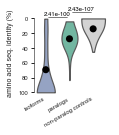

In [11]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=1.4, h=1.5)
violinplot_reflected(data=df,
            x='category',
            y='aa_seq_pct_identity',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            inner=None,
            width=1.,
            ub=100,
            bw_const=10,  # since on % scale
            cut=0,
            clip_on=False,
            ax=ax,
            palette=pal,
            )
sns.pointplot(data=df,
            x='category',
            y='aa_seq_pct_identity',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            color='black',
            linestyles='',
            ax=ax,
            clip_on=False,
            )
for loc in ['right', 'top', 'bottom']:
    ax.spines[loc].set_visible(False)
ax.set_ylim(0, 100)
ax.set_xlim(-0.5, 2.8)
ax.set_xlabel('')
ax.xaxis.set_tick_params(length=0)
ax.set_ylabel('amino acid seq. identity (%)')
ax.set_xticklabels(['isoforms', 'paralogs', 'non-paralog controls'], rotation=30, va='top', ha='right')

# calculate p-values
# isos v paralogs
dist_a = list(df[df['category'] == 'isoforms']['aa_seq_pct_identity'])
dist_a = [x for x in dist_a if not pd.isnull(x)]
dist_b = list(df[df['category'] == 'paralogs']['aa_seq_pct_identity'])
dist_b = [x for x in dist_b if not pd.isnull(x)]
u, p = stats.mannwhitneyu(dist_a, dist_b, alternative="two-sided")
print(p)
annotate_pval(ax, 0.1, 0.9, -2, 0, -2, p, PAPER_FONTSIZE - 1)

# paralogs v ctrls
dist_c = list(df[df['category'] == 'non-paralog-control']['aa_seq_pct_identity'])
dist_c = [x for x in dist_c if not pd.isnull(x)]
u, p = stats.mannwhitneyu(dist_b, dist_c, alternative="two-sided")
print(p)
annotate_pval(ax, 1.1, 1.9, -9, 0, -9, p, PAPER_FONTSIZE - 1)

# manually set left axis so it stops at 1.0
ax.set_ylim((101, -9))
ax.spines['left'].set_visible(False)
ax.set_yticks([100, 80, 60, 40, 20, 0])
axes_to_data = ax.transAxes + ax.transData.inverted()
left_spine_in_data_coords = axes_to_data.transform((0, 0))
ax.plot([left_spine_in_data_coords[0], left_spine_in_data_coords[0]], [100, 0],
         color=ax.spines['bottom'].get_edgecolor(), linewidth=ax.spines['bottom'].get_linewidth())

fig.savefig('../../figures/fig6/isoforms_vs_paralogs_seq_id_violin.pdf',
            bbox_inches='tight')

## 3. control for differences in sequence similarity

In [12]:
def assay_vs_seq_similarity_plot(
    var, 
    window_size,
    n_min,
    y_label,
    color,
    y_max=None,
    y_ticks=None,
    y_ticks_minor=None,
    y_pos_p_value=1,
    alpha_points=0.15,
    ):
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(2, 2)
    fig_path = f'../../figures/fig6/isoforms_vs_paralogs_aa_id_vs_{var}_fixed_window.pdf'

    # calculate bootstrap uncertainty by number of data points
    err = {}
    def get_bootstrap_error_for_n_data_points(n):
        if n in err:
            return err[n]
        all_vals = df[var].dropna().values
        rnd_means = []
        for _i in range(1000):
            rnd_means.append(
                np.mean(np.random.choice(all_vals, size=n, replace=True))
                )
        mean = np.mean(rnd_means)
        err_up = np.quantile(rnd_means, q=0.84) - mean
        err_dn = mean - np.quantile(rnd_means, q=0.16)
        err[n] = max([err_up, err_dn])  # taking a conservative approach
        return err[n]
                

    # p-value using permutation test within a window
    # use window where they overlap the most, as quantified by
    # the max across all windows of the min of the two #pairs 
    # (# paralog pairs and # isoform pairs) in each window
    max_min_n = 0
    for i in range(-window_size, 100):
        binned_rows = (df[var].notnull() 
                    & (df['aa_seq_pct_identity'] >= i)
                    & (df['aa_seq_pct_identity'] < i + window_size))
        min_n = min([
            (binned_rows & (df['category'] == 'isoforms')).sum(),
            (binned_rows & (df['category'] == 'paralogs')).sum()
        ])
        if min_n > max_min_n:
            bin_low = i
            bin_high = i + window_size
            max_min_n = min_n
    overlap = df.loc[df['category'].isin(['isoforms', 'paralogs'])
                    & df[var].notnull()
                    & (df['aa_seq_pct_identity'] >= bin_low)
                    & (df['aa_seq_pct_identity'] < bin_high),
                    ['category', var]]
    val_a = overlap.loc[overlap['category'] == 'isoforms', var].mean()
    val_b = overlap.loc[overlap['category'] == 'paralogs', var].mean()
    obs_val = val_a - val_b
    all_vals = overlap[var].values
    rnd_vals = []
    n_a = (overlap['category'] == 'isoforms').sum()
    np.random.seed(84349723)
    for _i in range(20000):
        shuffled = np.random.choice(all_vals, size=len(all_vals), replace=False)
        rnd_vals.append(shuffled[:n_a].mean() - shuffled[n_a:].mean())
    rnd_vals = np.array(rnd_vals)
    p_val = ((rnd_vals >= obs_val).sum() / len(rnd_vals)) * 2

    print(len(all_vals), n_a)
    print(val_a, val_b)
    print(bin_low, bin_high)
    print(obs_val)
    print('p=', p_val)

    for cat in ['isoforms', 'paralogs']:
        xy = df.loc[(df['category'] == cat) &
            (df[var].notnull()),
                ['aa_seq_pct_identity', var]].values
        ax.scatter(xy[:, 0], 
                xy[:, 1],
                clip_on=False, 
                alpha=alpha_points,
                label=cat,
                color=color[cat],
                lw=0,
                )
        x, avrg, ci_dn, ci_up = [], [], [], []
        for i in range(-window_size, 100):
            subset = df.loc[(df['category'] == cat) 
                            & (df[var].notnull())
                            & (df['aa_seq_pct_identity'] >= i)
                            & (df['aa_seq_pct_identity'] < i + window_size),
                            ['aa_seq_pct_identity', var]]
            n = subset.shape[0]
            if n < n_min:
                continue
            x.append(subset['aa_seq_pct_identity'].mean())
            avrg.append(subset[var].mean())
            ci_dn.append(max(avrg[-1] - get_bootstrap_error_for_n_data_points(n), 0))
            ci_up.append(min(avrg[-1] + get_bootstrap_error_for_n_data_points(n), y_max))

        ax.plot(x, avrg, color=color[cat])
        ax.fill_between(x=x, 
                        y1=ci_dn, 
                        y2=ci_up,
                        alpha=0.5,
                        color=color[cat],
                        lw=0,
                        )
    ax.text(s=f'P = {p_val:.3f}',
            x=bin_low + window_size / 2,
            y=y_pos_p_value,
            ha='center',
            va='top',
            )

    for loc in ['top', 'right']:
        ax.spines[loc].set_visible(False)
    ax.set_xlabel('% AA sequence ID')
    ax.set_xlim(0, 100)
    ax.set_ylim(0, y_max)
    ax.set_xticks(range(0, 101, 20))
    ax.set_xticks(range(0, 101, 10), minor=True)
    if y_ticks is not None:
        ax.set_yticks(y_ticks)
    if y_ticks_minor is not None:
        ax.set_yticks(y_ticks_minor, minor=True)
    ax.set_ylabel(y_label)
    #fig.legend(loc='center left', bbox_to_anchor=[0.95, 0.5])
    fig.savefig(fig_path, bbox_inches='tight')

47 20
0.9614468864468864 0.8680702014035347
29 69
0.09337668504335161
p= 0.0428


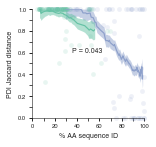

In [13]:
assay_vs_seq_similarity_plot(var='PDI_Jaccard_d',
                             window_size=40,
                             n_min=10,
                             y_label='PDI Jaccard distance',
                             color=pal,
                             y_max=1,
                             y_ticks=np.linspace(0, 1, 6),
                             y_ticks_minor=np.linspace(0, 1, 11),
                             y_pos_p_value=0.65,
                             )

45 23
0.6606398489520082 0.5508320052962911
33 73
0.10980784365571716
p= 0.1681


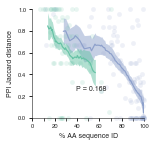

In [14]:
assay_vs_seq_similarity_plot(var='PPI_Jaccard_d',
                             window_size=40,
                             n_min=10,
                             y_label='PPI Jaccard distance',
                             color=pal,
                             y_max=1,
                             y_pos_p_value=0.3,
                             )

149 69
1.769598362355229 1.3539016001964117
36 76
0.41569676215881723
p= 0.0357


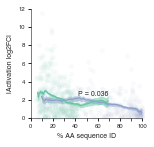

In [15]:
assay_vs_seq_similarity_plot(var='activation_abs_fold_change_log2',
                             window_size=40,
                             n_min=10,
                             y_label='|Activation log2FC|',
                             color=pal,
                             y_max=12,
                             alpha_points=0.05,
                             y_pos_p_value=3,                       
                             )

### binned violin-plots for main figure

In [16]:
def aa_seq_pct_identity_bin(row):
    if row.aa_seq_pct_identity >= 0 and row.aa_seq_pct_identity < 33.3:
        return "0-33%"
    elif row.aa_seq_pct_identity >= 33.3 and row.aa_seq_pct_identity < 66.6:
        return "33-66%"
    else:
        return "66-100%"
    
df["aa_seq_pct_identity_bin"] = df.apply(aa_seq_pct_identity_bin, axis=1)
df.aa_seq_pct_identity_bin.value_counts()

0-33%      1433
33-66%      394
66-100%     312
Name: aa_seq_pct_identity_bin, dtype: int64

0.2288638726083766
0.3599946474664366
0.45779681536661576


../plotting.py:1005: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1, c="black", linewidth=0.5)
../plotting.py:1005: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1, c="black", linewidth=0.5)
../plotting.py:1005: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1, c="black", linewidth=0.5)


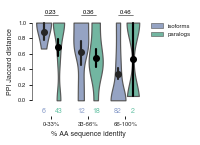

In [17]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=2, h=2)
violinplot_reflected(data=df,
            x='aa_seq_pct_identity_bin',
            order=['0-33%', '33-66%', '66-100%'],
            y='PPI_Jaccard_d',
            hue='category',
            hue_order=['isoforms', 'paralogs'],
            inner=None,
            clip_on=False,
            cut=0,
            bw_const=0.15,
            ax=ax,
            palette=pal
            )
sns.pointplot(data=df,
            x='aa_seq_pct_identity_bin',
            order=['0-33%', '33-66%', '66-100%'],
            y='PPI_Jaccard_d',
            hue='category',
            hue_order=['isoforms', 'paralogs'],
            color='black',
            linestyles='',
            ax=ax,
            clip_on=False,
            dodge=0.4,
            )
for loc in ['right', 'top', 'bottom']:
    ax.spines[loc].set_visible(False)
    
ax.set_xlabel("% AA sequence identity")
ax.set_ylabel("PPI Jaccard distance")

for i, x in enumerate(['0-33%', '33-66%', '66-100%']):
    _isos = df[(df['aa_seq_pct_identity_bin'] == x) &
               (df['category'] == 'isoforms') &
               (~pd.isnull(df['PPI_Jaccard_d']))]
    _pars = df[(df['aa_seq_pct_identity_bin'] == x) &
               (df['category'] == 'paralogs') &
               (~pd.isnull(df['PPI_Jaccard_d']))]
    n_isos = len(_isos)
    n_pars = len(_pars)
    ax.text(i-0.2, 0, '\n%s' % n_isos, color=pal['isoforms'], va='top', ha='center')
    ax.text(i+0.2, 0, '\n%s' % n_pars, color=pal['paralogs'], va='top', ha='center')
    
    u, p = stats.mannwhitneyu(_isos['PPI_Jaccard_d'], _pars['PPI_Jaccard_d'], alternative="two-sided")
    print(p)
    annotate_pval(ax, i-0.2, i+0.2, 1.1, 0, 1.1, p, PAPER_FONTSIZE - 1)


# manually set left axis so it stops at 1.0
ax.set_xlim((-0.5, 2.5))
ax.set_ylim((-0.2, 1.2))
ax.spines['left'].set_visible(False)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
axes_to_data = ax.transAxes + ax.transData.inverted()
left_spine_in_data_coords = axes_to_data.transform((0, 0))
ax.plot([left_spine_in_data_coords[0], left_spine_in_data_coords[0]], [0, 1],
         color=ax.spines['bottom'].get_edgecolor(), linewidth=ax.spines['bottom'].get_linewidth())
    

    
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles[0:2], labels=labels[0:2],
           loc=2, bbox_to_anchor=(1.01, 0.9), facecolor="white", markerscale=1,
           frameon=False)

fig.savefig('../../figures/fig6/isoforms_vs_paralogs_PPI_jaccard_violin.binned.pdf',
            bbox_inches='tight')

In [18]:
# fig, ax = plt.subplots(1, 1)
# fig.set_size_inches(w=3, h=2)

# sns.boxplot(data=df,
#             x='aa_seq_pct_identity_bin',
#             order=['0-33%', '33-66%', '66-100%'],
#             y='PPI_Jaccard_d',
#             hue='category',
#             hue_order=['isoforms', 'paralogs'],
#             ax=ax,
#             palette=pal,
#             fliersize=0,
#             )
# mimic_r_boxplot(ax=ax)

# sns.swarmplot(data=df,
#             x='aa_seq_pct_identity_bin',
#             order=['0-33%', '33-66%', '66-100%'],
#             y='PPI_Jaccard_d',
#             hue='category',
#             hue_order=['isoforms', 'paralogs'],
#             ax=ax,
#             palette=pal,
#             dodge=True,
#             linewidth=0.5,
#             edgecolor='black',
#             size=4
#             )
# for loc in ['right', 'top', 'bottom']:
#     ax.spines[loc].set_visible(False)
    
# ax.set_xlabel("% AA sequence identity")
# ax.set_ylabel("PPI Jaccard distance")

# for i, x in enumerate(['0-33%', '33-66%', '66-100%']):
#     _isos = df[(df['aa_seq_pct_identity_bin'] == x) &
#                (df['category'] == 'isoforms') &
#                (~pd.isnull(df['PPI_Jaccard_d']))]
#     _pars = df[(df['aa_seq_pct_identity_bin'] == x) &
#                (df['category'] == 'paralogs') &
#                (~pd.isnull(df['PPI_Jaccard_d']))]
#     u, p = stats.mannwhitneyu(_isos['PPI_Jaccard_d'], _pars['PPI_Jaccard_d'], alternative="two-sided")
#     print(p)
#     annotate_pval(ax, i-0.2, i+0.2, 1.1, 0, 1.1, p, PAPER_FONTSIZE - 1)
    
# # manually set left axis so it stops at 1.0
# ax.set_ylim((-0.1, 1.2))
# ax.spines['left'].set_visible(False)
# ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
# axes_to_data = ax.transAxes + ax.transData.inverted()
# left_spine_in_data_coords = axes_to_data.transform((0, 0))
# ax.plot([left_spine_in_data_coords[0], left_spine_in_data_coords[0]], [0, 1],
#          color=ax.spines['bottom'].get_edgecolor(), linewidth=ax.spines['bottom'].get_linewidth())
    
# handles, labels = ax.get_legend_handles_labels()
# plt.legend(handles=handles[0:2], labels=labels[0:2],
#            loc=2, bbox_to_anchor=(1.01, 0.9), facecolor="white", markerscale=1,
#            frameon=False)

# fig.savefig('../../figures/fig6/isoforms_vs_paralogs_PPI_jaccard_swarm.binned.pdf',
#             bbox_inches='tight')

0.5497489271984151
0.024346055164257988
0.5798297745398759


../plotting.py:1005: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1, c="black", linewidth=0.5)
../plotting.py:1005: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1, c="black", linewidth=0.5)
../plotting.py:1005: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1, c="black", linewidth=0.5)


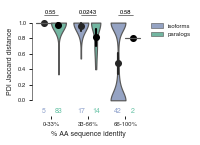

In [19]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=2, h=2)
violinplot_reflected(data=df,
            x='aa_seq_pct_identity_bin',
            order=['0-33%', '33-66%', '66-100%'],
            y='PDI_Jaccard_d',
            hue='category',
            hue_order=['isoforms', 'paralogs'],
            inner=None,
            clip_on=False,
            cut=0,
            bw_const=0.1,
            ax=ax,
            palette=pal
            )
sns.pointplot(data=df,
            x='aa_seq_pct_identity_bin',
            order=['0-33%', '33-66%', '66-100%'],
            y='PDI_Jaccard_d',
            hue='category',
            hue_order=['isoforms', 'paralogs'],
            color='black',
            linestyles='',
            ax=ax,
            clip_on=False,
            dodge=0.4,
            )
for loc in ['right', 'top', 'bottom']:
    ax.spines[loc].set_visible(False)
    
ax.set_xlabel("% AA sequence identity")
ax.set_ylabel("PDI Jaccard distance")

for i, x in enumerate(['0-33%', '33-66%', '66-100%']):
    _isos = df[(df['aa_seq_pct_identity_bin'] == x) &
               (df['category'] == 'isoforms') &
               (~pd.isnull(df['PDI_Jaccard_d']))]
    _pars = df[(df['aa_seq_pct_identity_bin'] == x) &
               (df['category'] == 'paralogs') &
               (~pd.isnull(df['PDI_Jaccard_d']))]
    n_isos = len(_isos)
    n_pars = len(_pars)
    ax.text(i-0.2, 0, '\n%s' % n_isos, color=pal['isoforms'], va='top', ha='center')
    ax.text(i+0.2, 0, '\n%s' % n_pars, color=pal['paralogs'], va='top', ha='center')
    
    u, p = stats.mannwhitneyu(_isos['PDI_Jaccard_d'], _pars['PDI_Jaccard_d'], alternative="two-sided")
    print(p)
    annotate_pval(ax, i-0.2, i+0.2, 1.1, 0, 1.1, p, PAPER_FONTSIZE - 1)


# manually set left axis so it stops at 1.0
ax.set_xlim((-0.5, 2.5))
ax.set_ylim((-0.2, 1.2))
ax.spines['left'].set_visible(False)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
axes_to_data = ax.transAxes + ax.transData.inverted()
left_spine_in_data_coords = axes_to_data.transform((0, 0))
ax.plot([left_spine_in_data_coords[0], left_spine_in_data_coords[0]], [0, 1],
         color=ax.spines['bottom'].get_edgecolor(), linewidth=ax.spines['bottom'].get_linewidth())
    

    
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles[0:2], labels=labels[0:2],
           loc=2, bbox_to_anchor=(1.01, 0.9), facecolor="white", markerscale=1,
           frameon=False)

fig.savefig('../../figures/fig6/isoforms_vs_paralogs_PDI_jaccard_violin.binned.pdf',
            bbox_inches='tight')

36 isos, 306 pars, p=0.4764968667307439
45 isos, 110 pars, p=0.07193002729434961
159 isos, 8 pars, p=0.026292618352087578


../plotting.py:1005: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1, c="black", linewidth=0.5)
../plotting.py:1005: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1, c="black", linewidth=0.5)
../plotting.py:1005: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1, c="black", linewidth=0.5)


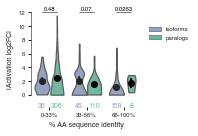

In [20]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=2, h=1.75)
violinplot_reflected(data=df,
            x='aa_seq_pct_identity_bin',
            order=['0-33%', '33-66%', '66-100%'],
            y='activation_abs_fold_change_log2',
            hue='category',
            hue_order=['isoforms', 'paralogs'],
            inner=None,
            clip_on=False,
            cut=0,
            bw_const=0.5,
            ub=999999,
            ax=ax,
            palette=pal
            )
sns.pointplot(data=df,
            x='aa_seq_pct_identity_bin',
            order=['0-33%', '33-66%', '66-100%'],
            y='activation_abs_fold_change_log2',
            hue='category',
            hue_order=['isoforms', 'paralogs'],
            color='black',
            linestyles='',
            ax=ax,
            clip_on=False,
            dodge=0.4,
            )
for loc in ['right', 'top', 'bottom']:
    ax.spines[loc].set_visible(False)
    
ax.set_xlabel("% AA sequence identity")
ax.set_ylabel("|Activation log2FC|")

for i, x in enumerate(['0-33%', '33-66%', '66-100%']):
    _isos = df[(df['aa_seq_pct_identity_bin'] == x) &
               (df['category'] == 'isoforms') &
               (~pd.isnull(df['activation_abs_fold_change_log2']))]
    _pars = df[(df['aa_seq_pct_identity_bin'] == x) &
               (df['category'] == 'paralogs') &
               (~pd.isnull(df['activation_abs_fold_change_log2']))]
    n_isos = len(_isos)
    n_pars = len(_pars)
    ax.text(i-0.2, 0, '\n%s' % n_isos, color=pal['isoforms'], va='top', ha='center')
    ax.text(i+0.2, 0, '\n%s' % n_pars, color=pal['paralogs'], va='top', ha='center')
    
    u, p = stats.mannwhitneyu(_isos['activation_abs_fold_change_log2'], _pars['activation_abs_fold_change_log2'], alternative="two-sided")
    print("%s isos, %s pars, p=%s" % (n_isos, n_pars, p))
    annotate_pval(ax, i-0.2, i+0.2, 12.1, 0, 12.1, p, PAPER_FONTSIZE - 1)


# manually set left axis so it stops at 1.0
ax.set_xlim((-0.5, 2.5))
ax.set_ylim((-1.75, 12.1))
ax.spines['left'].set_visible(False)
ax.set_yticks([0, 2, 4, 6, 8, 10, 12])
axes_to_data = ax.transAxes + ax.transData.inverted()
left_spine_in_data_coords = axes_to_data.transform((0, 0))
ax.plot([left_spine_in_data_coords[0], left_spine_in_data_coords[0]], [0, 12],
         color=ax.spines['bottom'].get_edgecolor(), linewidth=ax.spines['bottom'].get_linewidth())
    

    
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles[0:2], labels=labels[0:2],
           loc=2, bbox_to_anchor=(1.01, 0.9), facecolor="white", markerscale=1,
           frameon=False)

fig.savefig('../../figures/fig6/isoforms_vs_paralogs_activation_violin.binned.pdf',
            bbox_inches='tight')

## 4. THRA v. THRB vignette

In [21]:
def pairwise_global_aa_sequence_similarity(aa_seq_a, aa_seq_b):
    alignment = pairwise2.align.globalds(
        aa_seq_a, aa_seq_b, blosum62, -10, -0.5, penalize_end_gaps=False
    )
    alignment = pairwise2.format_alignment(*alignment[0])
    return alignment

In [22]:
# make alignment plot for the 2 ref isos of THRA/B
tfs = load_annotated_TFiso1_collection()
thra_aa_seq = tfs['THRA'].reference_isoform.aa_seq
thrb_aa_seq = tfs['THRB'].reference_isoform.aa_seq

reading from cache


In [23]:
algn = pairwise_global_aa_sequence_similarity(thra_aa_seq, thrb_aa_seq)
algn_str = algn.split("\n")[1]
algn_str

'                                                   ....|......             .|....||.......|.    |      .|||||||||||.|||||||||||||||||||||||||||||||||||.|||||...|||||.||||||.|||||||.||||.|||||||||.|||||||.|||.||.||...|....||||.|||.||...||||..||||||||||.|||||.||||.|||..|.|.||||||||.||||||||||||||||||||||.|||||||||||||||||||||||||||||||.||||.|||||.|.|||||||||||||||.||.|||.||||||||||||||||||.||.||.||..|||.|...|||||||.|.|||...||||||||||||||||||||||||||||||||||||||||||||||   '

In [24]:
algn_arr = np.zeros(len(algn_str))
for i, c in enumerate(algn_str):
    if c == ' ':
        algn_arr[i] = np.nan
    elif c == '|':
        algn_arr[i] = 1
    else:
        algn_arr[i] = 0.25

Pfam_domain: PF00105 zf-C4 51-122
Pfam_domain: PF00104 Hormone_recep 206-391
Pfam_domain: PF00105 zf-C4 105-176
Pfam_domain: PF00104 Hormone_recep 265-445


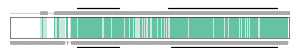

In [25]:
gs_kw = dict(height_ratios=[0.25, 0.75, 0.25])

fig, axs = plt.subplots(3, 1, sharex=True, gridspec_kw=gs_kw)
fig.set_size_inches(w=5, h=0.75)

## alignment plot
ax = axs[1]
cmap = sns.light_palette(pal["paralogs"], as_cmap=True)
sns.heatmap(pd.DataFrame(algn_arr).T, cmap=cmap, cbar=False, vmin=0, ax=ax)

ax.set_xticks([])
ax.set_yticks([])
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)

## THRA
ax = axs[0]
algn_a = algn.split("\n")[0]
dbd_start = tfs['THRA'].reference_isoform.dna_binding_domains[0].start
dbd_end = tfs['THRA'].reference_isoform.dna_binding_domains[0].end

for i, c in enumerate(algn_a):
    if c == '-':
        ax.plot([i, i+1], [0.25, 0.25], '-', color='lightgrey', zorder=1)
    else:
        ax.plot([i, i+1], [0.25, 0.25], '|', color='darkgrey', zorder=10)
        
# add domains
for d in tfs['THRA'].reference_isoform.aa_seq_features:
    if d.accession.endswith("_flank_N") or d.accession.endswith("_flank_C"):
        continue
    if "Effector" in d.accession:
        continue
    
    print(d)
    aa_i = 0
    for i, c in enumerate(algn_a):
        if c != "-":
            aa_i += 1
            if aa_i >= d.start and aa_i < d.end:
                ax.plot([i, i+1], [1, 1], '-', color='black')
                
    

ax.set_ylim((0, 1.2))
ax.set_yticks([])
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

## THRB
ax = axs[2]
algn_a = algn.split("\n")[2]

for i, c in enumerate(algn_a):
    if c == '-':
        ax.plot([i, i+1], [0.75, 0.75], '-', color='lightgrey', zorder=1)
    else:
        ax.plot([i, i+1], [0.75, 0.75], '|', color='darkgrey', zorder=10)
        
# add domains
for d in tfs['THRB'].reference_isoform.aa_seq_features:
    if d.accession.endswith("_flank_N") or d.accession.endswith("_flank_C"):
        continue
    if "Effector" in d.accession:
        continue
    
    print(d)
    aa_i = 0
    for i, c in enumerate(algn_a):
        if c != "-":
            aa_i += 1
            if aa_i >= d.start and aa_i < d.end:
                ax.plot([i, i+1], [0, 0], '-', color='black')
                
ax.set_ylim((-0.2, 1))
ax.set_yticks([])
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.savefig('../../figures/fig6/THRA_THRB_alignment.pdf',
            bbox_inches='tight')

In [26]:
df[(df['gene_symbol_a'] == 'THRA') & (df['gene_symbol_b'] == 'THRB')].iloc[0]

gene_symbol_a                                                          THRA
gene_symbol_b                                                          THRB
is_tested_in_Y2H                                                      False
aa_seq_pct_identity                                                 66.6667
clone_acc_a                                                  THRA|2/3|09H09
clone_acc_b                                                  THRB|2/2|07E08
category                                                           paralogs
family_a                                                   Nuclear receptor
family_b                                                   Nuclear receptor
is_MANE_select_isoform_cloned_a                                        True
is_MANE_select_isoform_cloned_b                                        True
is_MANE_select_isoform_cloned_both                                     True
n_positive_PPI_a                                                          0
n_positive_P

In [27]:
df[(df['gene_symbol_a'] == 'THRA') & (df['gene_symbol_b'] == 'THRA')].iloc[0]

gene_symbol_a                                                          THRA
gene_symbol_b                                                          THRA
is_tested_in_Y2H                                                        NaN
aa_seq_pct_identity                                                 84.7682
clone_acc_a                                                  THRA|2/3|09H09
clone_acc_b                                                  THRA|1/3|09H07
category                                                           isoforms
family_a                                                   Nuclear receptor
family_b                                                   Nuclear receptor
is_MANE_select_isoform_cloned_a                                        True
is_MANE_select_isoform_cloned_b                                        True
is_MANE_select_isoform_cloned_both                                     True
n_positive_PPI_a                                                          0
n_positive_P

In [28]:
df[(df['gene_symbol_a'] == 'THRB') & (df['gene_symbol_b'] == 'THRB')].iloc[0]

gene_symbol_a                                                          THRB
gene_symbol_b                                                          THRB
is_tested_in_Y2H                                                        NaN
aa_seq_pct_identity                                                 77.2819
clone_acc_a                                                  THRB|2/2|07E08
clone_acc_b                                                  THRB|1/2|07E05
category                                                           isoforms
family_a                                                   Nuclear receptor
family_b                                                   Nuclear receptor
is_MANE_select_isoform_cloned_a                                        True
is_MANE_select_isoform_cloned_b                                        True
is_MANE_select_isoform_cloned_both                                     True
n_positive_PPI_a                                                        NaN
n_positive_P

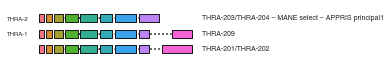

In [29]:
fig, ax = plt.subplots(figsize=(3, 1))

tfs["THRA"].exon_diagram(ax=ax)
fig.savefig("../../figures/fig6/{}_exon_diagram.pdf".format("THRA"), bbox_inches="tight", dpi="figure")

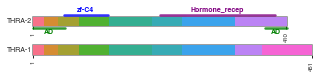

In [30]:
fig, ax = plt.subplots(figsize=(5, 0.7))

tfs["THRA"].protein_diagram(only_cloned_isoforms=True, draw_legend=False, ax=ax)
fig.savefig("../../figures/fig6/{}_protein_diagram.pdf".format("THRA"), bbox_inches="tight", dpi="figure")

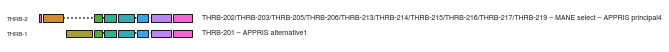

In [31]:
fig, ax = plt.subplots(figsize=(3, 0.7))

tfs["THRB"].exon_diagram(ax=ax)
fig.savefig("../../figures/fig6/{}_exon_diagram.pdf".format("THRB"), bbox_inches="tight", dpi="figure")

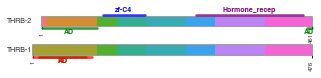

In [32]:
fig, ax = plt.subplots(figsize=(5, 0.7))

tfs["THRB"].protein_diagram(only_cloned_isoforms=True, draw_legend=False, ax=ax)
fig.savefig("../../figures/fig6/{}_protein_diagram.pdf".format("THRB"), bbox_inches="tight", dpi="figure")

In [33]:
tfs['THRB'].reference_isoform.aa_seq_features

[Pfam_domain: PF00105 zf-C4 105-176,
 Pfam_domain: PF00104 Hormone_recep 265-445,
 DBD_flank: PF00105_flank_N N_DBD_flank 90-104,
 DBD_flank: PF00105_flank_C C_DBD_flank 177-191,
 effector_domain: Soto_Effector 0775 AD 1-94,
 effector_domain: Soto_Effector 0776 AD 453-461]

In [34]:
tfs['THRB'].alternative_isoforms[0].aa_seq_features

[Pfam_domain: PF00105 zf-C4 120-191,
 Pfam_domain: PF00104 Hormone_recep 280-460,
 DBD_flank: PF00105_flank_N N_DBD_flank 105-119,
 DBD_flank: PF00105_flank_C C_DBD_flank 192-206,
 effector_domain: Soto_Effector 0776 AD 468-476,
 effector_domain: DelRosso_AD_THRB_1 AD 12-91,
 effector_domain: DelRosso_RD_THRB_1 RD 2-101]

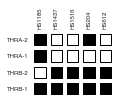

In [35]:
y1h = load_y1h_pdi_data()

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(h=1.2, w=1.5)
gene_name_a = 'THRA'
gene_name_b = 'THRB'
y1h_pdi_per_paralog_pair_plot(
    gene_name_a=gene_name_a,
    gene_name_b=gene_name_b,
    data=y1h,
    ax=ax,
    iso_order=([iso.name for iso in tfs[gene_name_a].cloned_isoforms] 
                + [iso.name for iso in tfs[gene_name_b].cloned_isoforms])
)
fig.savefig('../../figures/fig6/THRA-vs_THRB_Y1H_matrix.pdf',
            bbox_inches='tight')

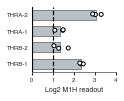

In [36]:
m1h = load_m1h_activation_data(add_missing_data=True)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(h=1.2, w=1.5)
gene_name_a = 'THRA'
gene_name_b = 'THRB'
m1h_activation_per_paralog_pair_plot(
    gene_name_a=gene_name_a,
    gene_name_b=gene_name_b,
    data=m1h,
    ax=ax,
    xlim=(0, 4),
    iso_order=([iso.name for iso in tfs[gene_name_a].cloned_isoforms] 
                + [iso.name for iso in tfs[gene_name_b].cloned_isoforms])
)
fig.savefig('../../figures/fig6/THRA-vs_THRB_m1h_l2fc.pdf',
            bbox_inches='tight')

## 5. examine expression profiles of isos vs. paralogs

In [37]:
df_gtex, metadata_gtex, genes_gtex = load_gtex_remapped()

exclusion_list_gtex = {'Cells - Leukemia cell line (CML)',
                       'Cells - EBV-transformed lymphocytes',
                       'Cells - Cultured fibroblasts'}

df_gtex = df_gtex.loc[:, ~df_gtex.columns.map(metadata_gtex['body_site']).isin(exclusion_list_gtex)]
metadata_gtex = metadata_gtex.loc[~metadata_gtex['body_site'].isin(exclusion_list_gtex), :]

means_gtex = df_gtex.groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1).mean()

reading from cache


In [38]:
metadata_gtex_dummy = pd.read_table("../../data/processed/metadata_gtex_dummy.csv", sep=",", index_col=0)

In [39]:
# use same downsample as prev figs
means_gtex_downsample = df_gtex.groupby(df_gtex.columns.map(metadata_gtex_dummy['body_site']), axis=1).mean()

In [40]:
df_dev, metadata_dev, genes_dev = load_developmental_tissue_expression_remapped()

rename_dev_stage = {'8 week post conception,embryo': '08',
'11 week post conception,late embryo': '11',
'embryo,7 week post conception': '07',
'infant': 'infant',
'10 week post conception,late embryo': '10',
'young adult': 'young adult',
'13 week post conception,late embryo': '13',
'16 week post conception,late embryo': '16',
'4 week post conception,embryo': '04',
'neonate': 'neonate',
'19 week post conception,late embryo': '19',
'9 week post conception,late embryo': '09',
'adolescent': 'adolescent',
'5 week post conception,embryo': '05',
'embryo,6 week post conception': '06',
'12 week post conception,late embryo': '12',
'18 week post conception,late embryo': '18',
'toddler': 'toddler',
'elderly': 'elderly',
'middle adult': 'adult',
'school age child': 'child'}

metadata_dev['dev_stage'] = metadata_dev['Developmental_Stage'].map(rename_dev_stage)
means_dev = (df_dev.groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']), axis=1)
           .mean())

reading from cache


In [41]:
# calculate expression ratios - dev
per_gene_dev = ((2 ** df_dev - 1)
                .groupby(genes_dev)
                .transform('sum'))
f_dev = (((2 ** df_dev - 1) / per_gene_dev)
        .groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']),
         axis=1)
        .mean())
f_dev = f_dev * ((per_gene_dev.groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']),
                                             axis=1)
                                             .mean() >= 1)
                                         .applymap(lambda x: {False: np.nan, True: 1}[x]))  # only count fractions if gene TPM is >= 1

f_dev = f_dev * 100

In [42]:
# calculate expression ratios - gtex
per_gene_gtex = ((2 ** df_gtex - 1)
                .groupby(genes_gtex)
                .transform('sum'))
f_gtex = (((2 ** df_gtex - 1) / per_gene_gtex)
        .groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1)
        .mean())
f_gtex = f_gtex * (per_gene_gtex.groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1).mean() >= 1).applymap(lambda x: {False: np.nan, True: 1}[x])  # only count fractions if gene TPM is >= 1

f_gtex = f_gtex * 100

In [43]:
# calculate expression ratios -gtex downsampled
per_gene_gtex_ds = ((2 ** df_gtex.loc[:,metadata_gtex_dummy.index] - 1)
                   .groupby(genes_gtex)
                   .transform('sum'))

f_gtex_downsample = (((2 ** df_gtex - 1) / per_gene_gtex)
        .groupby(df_gtex.columns.map(metadata_gtex_dummy['body_site']), axis=1)
        .mean())
f_gtex_downsample = f_gtex_downsample * (per_gene_gtex.groupby(df_gtex.columns.map(metadata_gtex_dummy['body_site']), axis=1).mean() >= 1).applymap(lambda x: {False: np.nan, True: 1}[x])  # only count fractions if gene TPM is >= 1

f_gtex_downsample = f_gtex_downsample * 100

In [44]:
if not (genes_gtex == genes_dev).all():
        raise UserWarning()
genes = genes_gtex

In [45]:
def developmental_tissue_expression_plot(gene_name, palette_name, figsize, ylim, means, cols, fig_suffix):
    n_isos = len(means.loc[genes == gene_name])
    palette = sns.color_palette(palette_name, as_cmap=False, n_colors=n_isos)
    fig, axes = plt.subplots(2, 1, sharex=True)
    fig.set_size_inches(figsize)
    ### bar chart ###
    (means.loc[genes == gene_name, cols]
          .T
          .plot.bar(ax=axes[0],
                    legend=False,
                    width=0.7,
                    color=list(palette)))
    ### percentages ###
    raw_means = 2 ** means.loc[genes == gene_name, cols] - 1.
    (raw_means.div(raw_means.sum(axis=0))
              .T.plot.bar(ax=axes[1], 
                          stacked=True,
                          legend=False,
                          color=list(palette)))
    axes[0].set_ylabel('log2(tpm + 1)\n')
    axes[0].set_ylim(ylim)
    axes[1].set_ylabel('percent')
    axes[1].set_yticklabels(['{:.0%}'.format(t) for t in axes[1].get_yticks()])
    axes[1].legend(loc='lower left', bbox_to_anchor=(1, 0), frameon=False)
    axes[0].axhline(y=1, color='black', linewidth=0.5, linestyle="dashed")
    
    for spine in ['right', 'top']:
        axes[0].spines[spine].set_visible(False)
        axes[1].spines[spine].set_visible(False)
    
    plt.subplots_adjust(hspace=0.25)
    plt.savefig('../../figures/fig6/expression_' + gene_name + '_' + fig_suffix + '.pdf',
                bbox_inches='tight')

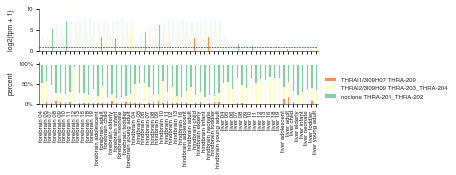

In [46]:
brain_cols = [x for x in means_dev.columns if "brain" in x]
liver_cols = [x for x in means_dev.columns if "liver" in x]
developmental_tissue_expression_plot("THRA", "Spectral", (5, 1.75), (0, 10), means_dev, brain_cols + liver_cols, 
                                     "means_dev_brain_liver")

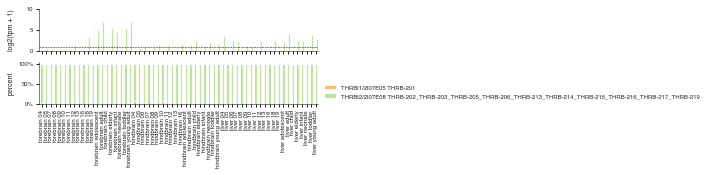

In [47]:
brain_cols = [x for x in means_dev.columns if "brain" in x]
liver_cols = [x for x in means_dev.columns if "liver" in x]
developmental_tissue_expression_plot("THRB", "Spectral", (5, 1.75), (0, 10), means_dev, brain_cols + liver_cols, 
                                     "means_dev_brain_liver")

## 6. examine ZF arrays in isoforms

In [48]:
tfs = load_annotated_TFiso1_collection()
zfs = {name: gene for name, gene in tfs.items() if gene.tf_family == 'C2H2 ZF'}

reading from cache


In [49]:
print(len(zfs), 'ZF genes with at least one cloned isoform')
print(sum(len(zf.cloned_isoforms) >= 2 for zf in zfs.values()), 'ZF genes with at least two cloned isoforms')

101 ZF genes with at least one cloned isoform
101 ZF genes with at least two cloned isoforms


In [50]:
def has_KRAB(gene):
    return any(d.name == 'KRAB' for d in gene.reference_isoform.aa_seq_features)

def has_SCAN(gene):
    return any(d.name == 'SCAN' for d in gene.reference_isoform.aa_seq_features)

def has_BTB(gene):
    return any(d.name == 'BTB' for d in gene.reference_isoform.aa_seq_features)


print(sum(has_KRAB(zf) for zf in zfs.values()), 'KRAB domain containing')
print(sum(has_SCAN(zf) for zf in zfs.values()), 'SCAN domain containing')
print(sum(has_BTB(zf) for zf in zfs.values()), 'BTB domain containing')
print(sum(has_KRAB(zf) and has_SCAN(zf) for zf in zfs.values()), 'KRAB & SCAN domain containing')
print(sum(has_KRAB(zf) and has_SCAN(zf) and has_BTB(zf) for zf in zfs.values()), 'KRAB & SCAN & BTB domain containing')
print(sum(has_SCAN(zf) and has_BTB(zf) for zf in zfs.values()), 'SCAN & BTB domain containing')
print(sum(has_KRAB(zf) and has_BTB(zf) for zf in zfs.values()), 'KRAB & BTB domain containing')

46 KRAB domain containing
16 SCAN domain containing
8 BTB domain containing
8 KRAB & SCAN domain containing
0 KRAB & SCAN & BTB domain containing
0 SCAN & BTB domain containing
0 KRAB & BTB domain containing


In [51]:
pfam_to_clan = load_pfam_clans()
clan_to_pfam = {clan: {p for p, c in pfam_to_clan.items() if c == clan} for clan in set(pfam_to_clan.values())}

In [52]:
df = pd.DataFrame(data=[(zf.name, 
                    zf.cloned_reference_isoform.name,
                    iso.name,
                    len([iso for iso in zf.isoforms if not (hasattr(iso, 'is_novel_isoform') and  iso.is_novel_isoform())]),
                    len(zf.cloned_isoforms),
                    len([iso for iso in zf.cloned_isoforms if iso.is_novel_isoform()]),
                    zf.cloned_MANE_select_isoform,
                    has_KRAB(zf),
                    has_SCAN(zf),
                    has_BTB(zf)
                    ) 
                    for zf in zfs.values()
                    for iso in zf.cloned_isoforms
                    if iso != zf.cloned_reference_isoform],
             columns=['gene_symbol',
                     'ref_iso',
                     'alt_iso',
                     'n_gencode_iso',
                     'n_cloned_iso',
                     'n_novel_iso',
                     'cloned_ref_is_MANE',
                     'is_KRAB',
                     'is_SCAN',
                     'is_BTB'])
df['cat'] = np.nan
df.loc[df['is_KRAB'] & ~df['is_SCAN'], 'cat'] = 'KRAB'
df.loc[~df['is_KRAB'] & df['is_SCAN'], 'cat'] = 'SCAN'
df.loc[df['is_KRAB'] & df['is_SCAN'], 'cat'] = 'KRAB+SCAN'
df.loc[df['is_BTB'], 'cat'] = 'BTB'
df.loc[~df['is_KRAB'] & ~df['is_SCAN'] & ~df['is_BTB'], 'cat'] = 'other ZF'

def count_c2h2_zf_in_iso(iso_name):
    C2H2_ZF_PFAM_CLAN_ID = 'CL0361'
    c2h2_zf_pfam_accessions = clan_to_pfam[C2H2_ZF_PFAM_CLAN_ID]
    doubles = {'PF12756',  # C2H2 type zinc-finger (2 copies)
               'PF13465',  # Zinc-finger double domain
    }
    count = 0
    for dom in zfs[iso_name.split('-')[0]][iso_name].aa_seq_features:
        if dom.category == 'ZF_array':
            count += int(dom.name.split('_')[-1])
        elif dom.category == 'Pfam_domain':
            # todo double count for double ZF
            if dom.accession in c2h2_zf_pfam_accessions:
                if dom.accession in doubles:
                    count += 2
                else:
                    count += 1
    return count

df['n_ZF_ref'] = df['ref_iso'].apply(count_c2h2_zf_in_iso)
df['n_ZF_alt'] = df['alt_iso'].apply(count_c2h2_zf_in_iso)

In [53]:
n_zf_max = df['n_ZF_ref'].max()

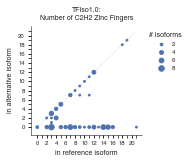

In [54]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(2, 2)
scaling = 4

to_plot = ((df.loc[(df['cloned_ref_is_MANE'] == True) | df['cloned_ref_is_MANE'].isnull()]
.groupby(['n_ZF_ref', 'n_ZF_alt'])
.size()
* scaling)
.rename('count')
.reset_index())

ax.plot([0, n_zf_max], [0, n_zf_max], linestyle="dashed", linewidth=0.5, color="lightgrey", zorder=1) 
sc = ax.scatter(x=to_plot['n_ZF_ref'], y=to_plot['n_ZF_alt'], s=to_plot['count'], zorder=10)


ax.set_xticks(range(0, n_zf_max + 1, 2))
ax.set_yticks(range(0, n_zf_max + 1, 2))
ax.set_xticks(range(0, n_zf_max + 1), minor=True)
ax.set_yticks(range(0, n_zf_max + 1), minor=True)
ax.set_title("TFIso1.0:\nNumber of C2H2 Zinc Fingers")
ax.set_xlabel('in reference isoform')
ax.set_ylabel('in alternative isoform')

for loc in ['top', 'right']:
    ax.spines[loc].set_visible(False)
    
# add legend
handles, labels = sc.legend_elements(prop='sizes', num=4)
for handle in handles:
    handle.set_color(sns.color_palette()[0])
    
new_labels = [int(int(''.join(i for i in x if i.isdigit()))/scaling) for x in labels]
legend = ax.legend(handles, new_labels, loc=2, title="# isoforms", bbox_to_anchor=(1.01, 1),
                   frameon=False, title_fontsize=PAPER_FONTSIZE)
        
fig.savefig('../../figures/fig6/n-ZF_ref-vs-alt_scatter.pdf',
            bbox_inches='tight')

In [55]:
tfs_all = load_annotated_gencode_tfs()
zfs_all = {name: gene for name, gene in tfs_all.items() if gene.tf_family == 'C2H2 ZF'}
df_all = pd.DataFrame(data=[(zf.name, 
                    zf.reference_isoform.name,
                    iso.name,
                    len([iso for iso in zf.isoforms if not (hasattr(iso, 'is_novel_isoform') and  iso.is_novel_isoform())]),
                    has_KRAB(zf),
                    has_SCAN(zf),
                    has_BTB(zf)
                    ) 
                    for zf in zfs_all.values()
                    for iso in zf.isoforms],
             columns=['gene_symbol',
                     'ref_iso',
                     'alt_iso',
                     'n_gencode_iso',
                     'is_KRAB',
                     'is_SCAN',
                     'is_BTB'])
df_all['cat'] = np.nan
df_all.loc[df_all['is_KRAB'] & ~df_all['is_SCAN'], 'cat'] = 'KRAB'
df_all.loc[~df_all['is_KRAB'] & df_all['is_SCAN'], 'cat'] = 'SCAN'
df_all.loc[df_all['is_KRAB'] & df_all['is_SCAN'], 'cat'] = 'KRAB+SCAN'
df_all.loc[df_all['is_BTB'], 'cat'] = 'BTB'
df_all.loc[~df_all['is_KRAB'] & ~df_all['is_SCAN'] & ~df_all['is_BTB'], 'cat'] = 'other ZF'

reading from cache


In [56]:
def count_c2h2_zf_in_iso(row, iso_col):
    iso_name = row[iso_col]
    gene_name = row['gene_symbol']
    C2H2_ZF_PFAM_CLAN_ID = 'CL0361'
    c2h2_zf_pfam_accessions = clan_to_pfam[C2H2_ZF_PFAM_CLAN_ID]
    doubles = {'PF12756',  # C2H2 type zinc-finger (2 copies)
               'PF13465',  # Zinc-finger double domain
    }
    count = 0
    for dom in zfs_all[gene_name][iso_name].aa_seq_features:
        if dom.category == 'ZF_array':
            count += int(dom.name.split('_')[-1])
        elif dom.category == 'Pfam_domain':
            # todo double count for double ZF
            if dom.accession in c2h2_zf_pfam_accessions:
                if dom.accession in doubles:
                    count += 2
                else:
                    count += 1
    return count

In [57]:
df_all['n_ZF_ref'] = df_all.apply(count_c2h2_zf_in_iso, iso_col='ref_iso', axis=1)
df_all['n_ZF_alt'] = df_all.apply(count_c2h2_zf_in_iso, iso_col='alt_iso', axis=1)

In [58]:
n_zf_max_all = df_all['n_ZF_ref'].max()

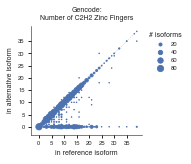

In [59]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(2, 2)
scaling = 0.5

to_plot = ((df_all
.groupby(['n_ZF_ref', 'n_ZF_alt'])
.size())
.rename('count')
.reset_index())
to_plot['scale'] = to_plot['count'] * scaling

ax.plot([0, n_zf_max_all], [0, n_zf_max_all], linestyle="dashed", linewidth=0.5, color="lightgrey", zorder=1) 
sc = ax.scatter(x=to_plot['n_ZF_ref'], y=to_plot['n_ZF_alt'], s=to_plot['scale'], zorder=10)


ax.set_xticks(range(0, n_zf_max_all + 1, 5))
ax.set_yticks(range(0, n_zf_max_all + 1, 5))
ax.set_title("Gencode:\nNumber of C2H2 Zinc Fingers")
ax.set_xlabel('in reference isoform')
ax.set_ylabel('in alternative isoform')

for loc in ['top', 'right']:
    ax.spines[loc].set_visible(False)
    
# add legend
handles, labels = sc.legend_elements(prop='sizes', num=4)
for handle in handles:
    handle.set_color(sns.color_palette()[0])
    
new_labels = [int(int(''.join(i for i in x if i.isdigit()))/scaling) for x in labels]
legend = ax.legend(handles, new_labels, loc=2, title="# isoforms", bbox_to_anchor=(1.01, 1),
                   frameon=False, title_fontsize=PAPER_FONTSIZE)
        
fig.savefig('../../figures/fig6/n-ZF_ref-vs-alt_scatter.all.pdf',
            bbox_inches='tight')

## 7. make supp file

In [60]:
# reload since we over-wrote it earlier
df = load_paralogs_vs_isoforms_comparison_table()
df.loc[~((df['n_positive_PPI_a'] >= 1) & (df['n_positive_PPI_b'] >= 1)),
       'PPI_jaccard'] = np.nan
df['PPI_Jaccard_d'] = 1 - df['PPI_jaccard']
df['PDI_Jaccard_d'] = 1 - df['PDI_jaccard']
df.loc[(df['activation_a'].abs() < 1) &
       (df['activation_b'].abs() < 1), 
       'activation_abs_fold_change_log2'] = np.nan

In [61]:
# map clone_acc to clone_name
clone_acc_map = {}

for gene in tfs:
    for iso in tfs[gene].cloned_isoforms:
        clone_acc = iso.clone_acc
        clone_name = iso.name
        clone_acc_map[clone_acc] = clone_name

In [62]:
supp_paralogs = df.copy()
supp_paralogs["clone_id_a"] = supp_paralogs["clone_acc_a"].apply(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])
supp_paralogs["clone_id_b"] = supp_paralogs["clone_acc_b"].apply(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])

supp_paralogs = supp_paralogs[["gene_symbol_a", "clone_id_a", "gene_symbol_b", "clone_id_b", "category", 
                               "aa_seq_pct_identity", "PDI_Jaccard_d", "PPI_Jaccard_d", 
                               "activation_abs_fold_change_log2"]]
supp_paralogs.category.value_counts()

paralogs               874
non-paralog-control    818
isoforms               447
Name: category, dtype: int64

In [63]:
supp_paralogs.to_csv("../../supp/SuppTable_Paralogs.txt", sep="\t", index=False)